# Street network processing

Input street network normally represents transportation network. However, that comes with dual lines, roundabouts and other transportation focused features, which causes imprecision of morphometric analysis.

Currently, preprocessing aims to consolidate nodes and edges of street network to get morphological, not trasporation geometry.

`consolidate` function is loaded from `consolidate.py`.

In [1]:
import geopandas as gpd

from consolidate import consolidate

In [2]:
help(consolidate)

Help on function consolidate in module consolidate:

consolidate(network, distance=2, epsilon=2, filter_func=<function filter_comp at 0x7f89f1c369d0>, **kwargs)
    Consolidate edges of a network, takes care of geometry only. No
    attributes are preserved at the moment.
    
    The whole process is split into several steps:
    1. Polygonize network
    2. Find polygons which are likely caused by dual lines and other
       geometries to be consolidated.
    3. Iterate over those polygons and generate averaged geometry
    4. Remove invalid and merge together with new geometry.
    
    Step 2 needs work, this is just a first attempt based on shape and area
    of the polygon. We will have to come with clever options here and
    allow their specification, because each network will need different
    parameters.
    
    Either before or after these steps needs to be done node consolidation,
    but in a way which does not generate overlapping geometries.
    Overlapping geometries 

In [3]:
network = gpd.read_file("https://gist.githubusercontent.com/martinfleis/367b3cb8f5c5a3f2c5b121174ef79990/raw/63290816c4834320233a2588c64317c9f47e3ed6/sample.geojson")

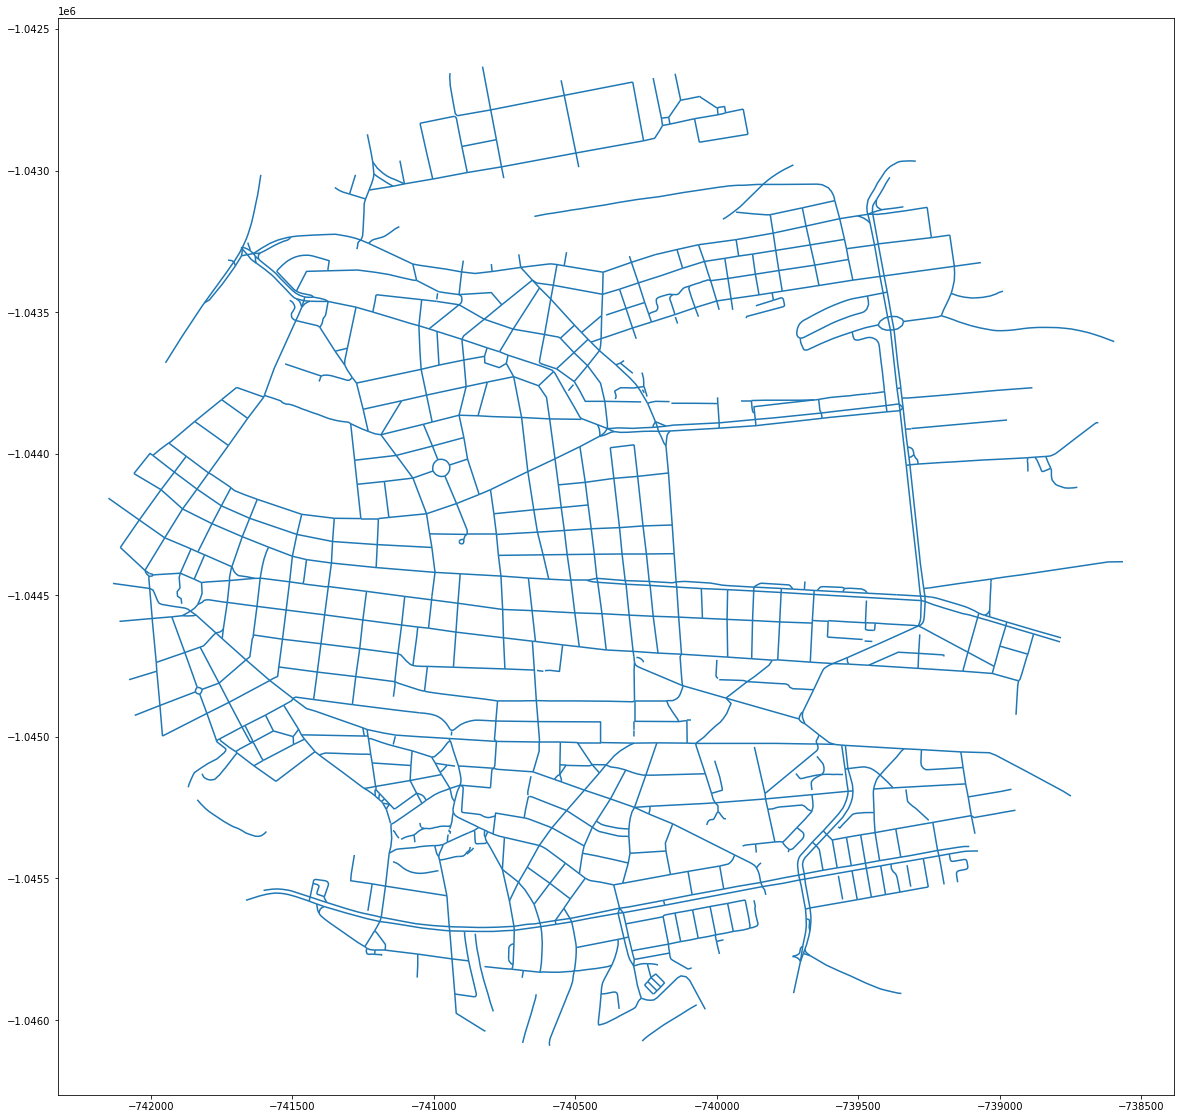

In [4]:
network.plot(figsize=(20, 20))

In [5]:
consolidated = consolidate(network)

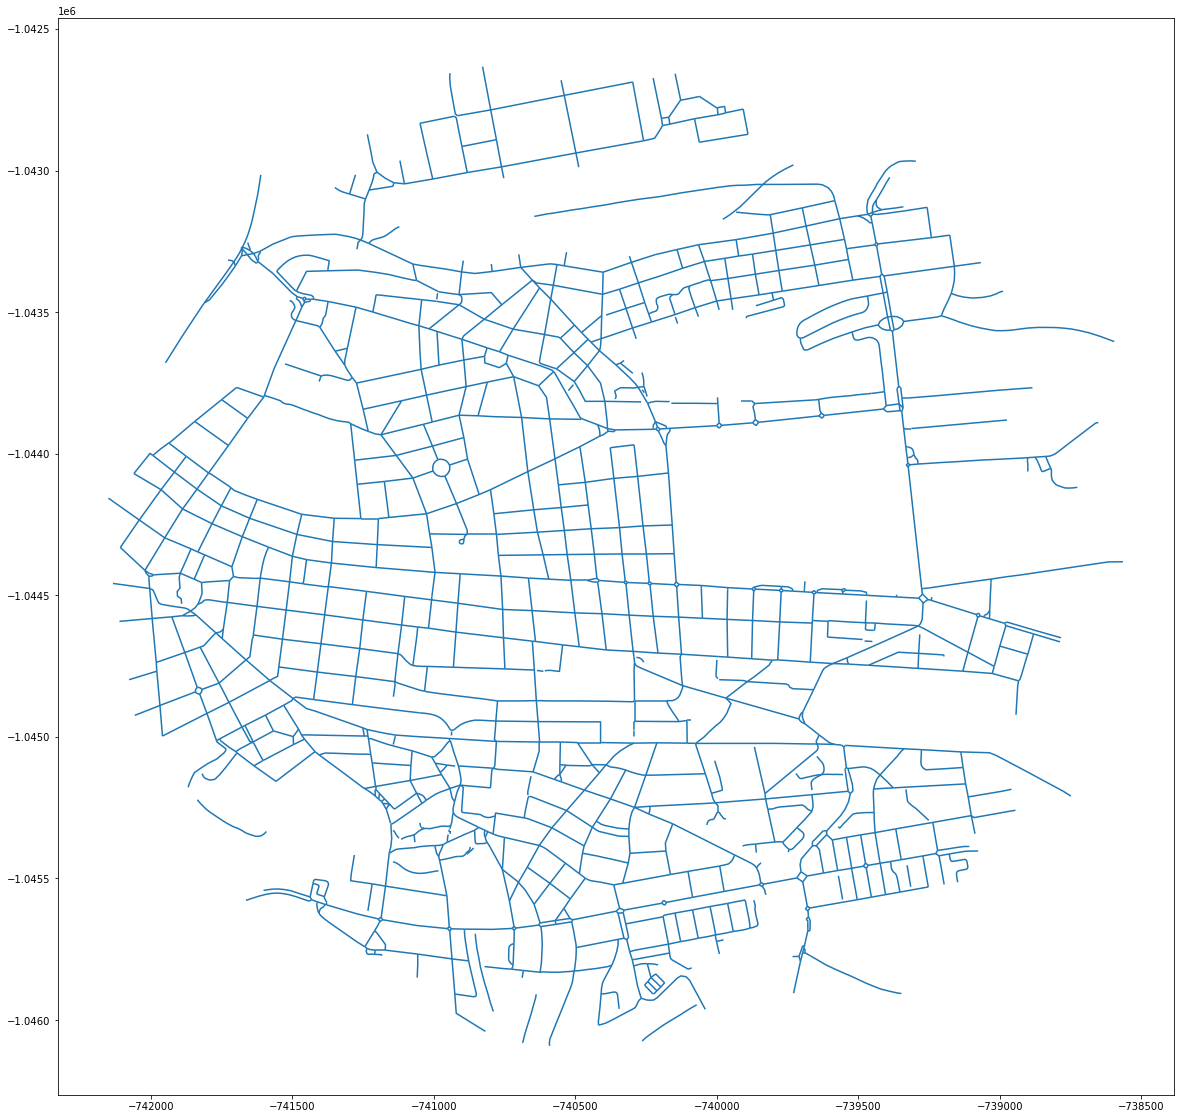

In [6]:
consolidated.plot(figsize=(20, 20))

TODO:

- figure out clever way of adaptable filters (to identify which polygons should not be there, i.e. which edges should be consolidated)
- triple/quadruple lines
- consolidate nodes in geometrical manner before (or after) edge consolidation. Current implementation of node consolidation creates overlapping lines causing issues with Voronoi. The optimal result should be spider-like.
- implementation into OSMnx, which has to deal with a mess of OSM (overlapping geometries)
- make it work for both GeoDataFrames and Graph


## OpenRoads

The main issue on OpenRoads seems to be roundabouts, dual routes are mostly removed already. Some of them have attribute, some not, so we should not depend on it.


In [2]:
from shapely.geometry import Point


pt = Point(335237.8, 396391.6)

df = gpd.read_file('oproad_gpkg_gb/data/oproad_gb.gpkg', mask=pt.buffer(1000))

In [6]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 926 entries, 0 to 925
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   id                        926 non-null    object  
 1   endNode                   926 non-null    object  
 2   startNode                 926 non-null    object  
 3   roadNumberTOID            122 non-null    object  
 4   roadNameTOID              695 non-null    object  
 5   fictitious                926 non-null    bool    
 6   roadClassification        926 non-null    object  
 7   roadFunction              926 non-null    object  
 8   formOfWay                 926 non-null    object  
 9   length                    926 non-null    int64   
 10  length_uom                926 non-null    object  
 11  loop                      926 non-null    bool    
 12  primaryRoute              926 non-null    bool    
 13  trunkRoad                 926 non-null    

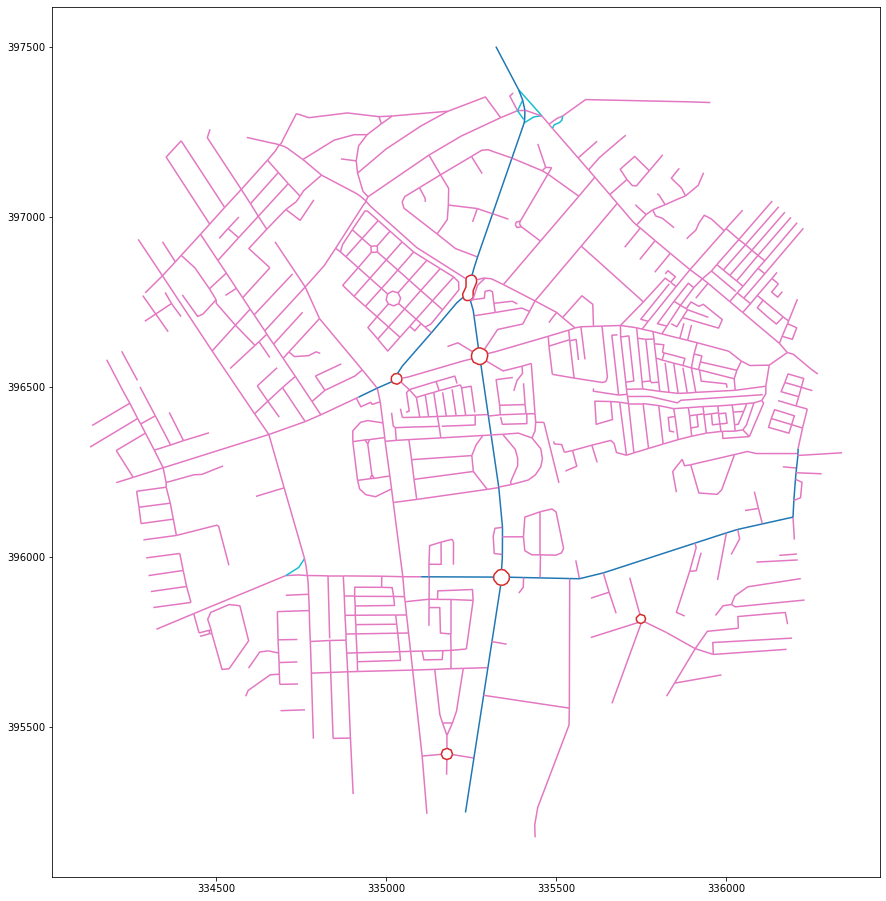

In [3]:
df.plot('formOfWay', figsize=(16, 16))

In [4]:
def roundabouts(gdf, area=5000, circom=.6):

    import momepy as mm

    # calculate parameters
    gdf["area"] = gdf.geometry.area
    gdf["circom"] = mm.CircularCompactness(gdf, "area").series
    # select valid and invalid network-net_blocks
    mask = (gdf["area"] < area) & (gdf["circom"] > circom)
    return mask


In [5]:
cons = consolidate(df, filter_func=roundabouts, area=2500)

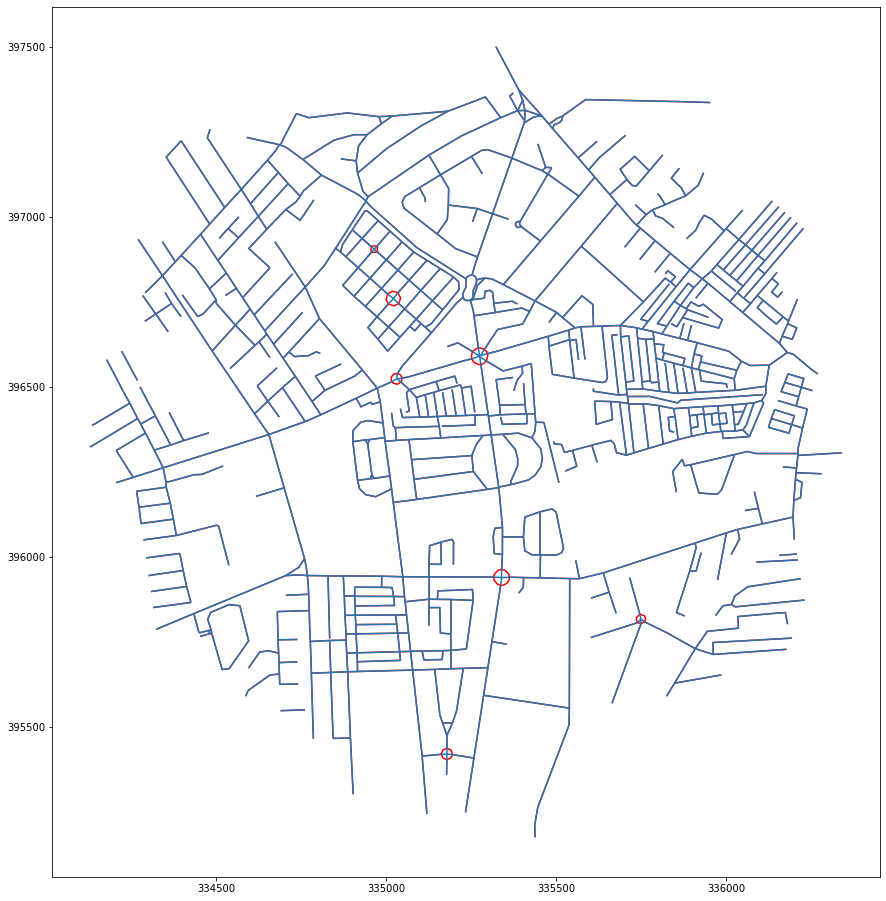

In [6]:
ax = cons.plot(figsize=(16, 16))
df.plot(ax=ax, color='r', zorder=0)

In [29]:
cons

0      LINESTRING (335178.904 395420.974, 335178.650 ...
1      LINESTRING (335195.440 395419.370, 335178.904 ...
2                               GEOMETRYCOLLECTION EMPTY
3      LINESTRING (335178.805 395421.084, 335178.904 ...
4      LINESTRING (335178.805 395421.084, 335162.170 ...
                             ...                        
921    LINESTRING (335564.880 397174.680, 335580.210 ...
922    LINESTRING (335519.380 397298.000, 335586.830 ...
923    LINESTRING (335705.100 397241.460, 335695.600 ...
924    LINESTRING (335322.930 397502.230, 335356.400 ...
925    LINESTRING (335389.870 397375.240, 335395.840 ...
Length: 952, dtype: geometry